In [32]:
#1.Carregamento e pré-processamento dos dados
from itertools import product
from typing import Optional
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, r2_score
import statsmodels.formula.api as smf

data = load_breast_cancer()
X, y = data.data, data.target

In [11]:
random_seed = 42

# Parâmetros de Data Augmentation
use_noise = True

center_stat = 'median'
select_by_center_stat = True

# KNN
ks = [k for k in range(1, 27, 2)] 
k_min = 1
k_max = 11
distance_metric = 'euclidean'
weights = 'uniform'
holdout_size = 0.2
k_of_k_folds = 5
n_splits = 10  
change_operation_point = False

evaluation_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
evaluation_pick = 'f1_score'
picking_stat = 'all' # holdout, all

In [12]:
#2.Treinamento e avaliação de modelos de classificação usando o algoritimo KNN - baseline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

best_knn = KNeighborsClassifier(n_neighbors=7)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print(f"Acurácia Final: {accuracy_score(y_test, y_pred):.4f}")


Matriz de Confusão:
[[40  3]
 [ 3 68]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Acurácia Final: 0.9474


In [25]:
#3.Geração e uso de dados sintéticos com ruído para simular aumento da base
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
accuracies_list = []

# Realizar K-Folds
ix_fold = 0

for k in ks:
    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Data Augmentation - Ruído gaussiano
        if use_noise:
            noise_factor = 0.1
            noise = np.random.normal(loc=0.0, scale=noise_factor, size=X_train.shape)
            X_train_noisy = X_train + noise
            X_train_aug = np.concatenate([X_train, X_train_noisy], axis=0)
            y_train_aug = np.concatenate([y_train, y_train], axis=0)
        else:
            X_train_aug, y_train_aug = X_train, y_train

        # Treinar o modelo
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric, n_jobs=-1, weights=weights)
        knn.fit(X_train_aug, y_train_aug)
        
        # Predição e avaliação
        y_pred = knn.predict(X_test)
        train_accuracy = accuracy_score(y_train_aug, knn.predict(X_train_aug))
        test_accuracy = accuracy_score(y_test, knn.predict(X_test))
        accuracy = accuracy_score(y, knn.predict(X_scaled))
        accuracies_list.append({'k': k, 'fold': ix_fold, 'stat' : 'train', 'accuracy': train_accuracy})
        accuracies_list.append({'k': k, 'fold': ix_fold, 'stat' : 'test', 'accuracy': test_accuracy})
        accuracies_list.append({'k': k, 'fold': ix_fold, 'stat' : 'all', 'accuracy': accuracy})
        
        ix_fold += 1

accuracies = pd.DataFrame.from_records(accuracies_list)
accuracies

,k,fold,stat,accuracy
0,11,0,train,0.972656
1,11,0,test,0.982456
2,11,0,all,0.973638
3,11,1,train,0.972656
4,11,1,test,0.982456
...,...,...,...,...
175,1,58,test,0.964912
176,1,58,all,0.996485
177,1,59,train,1.000000
178,1,59,test,0.982143


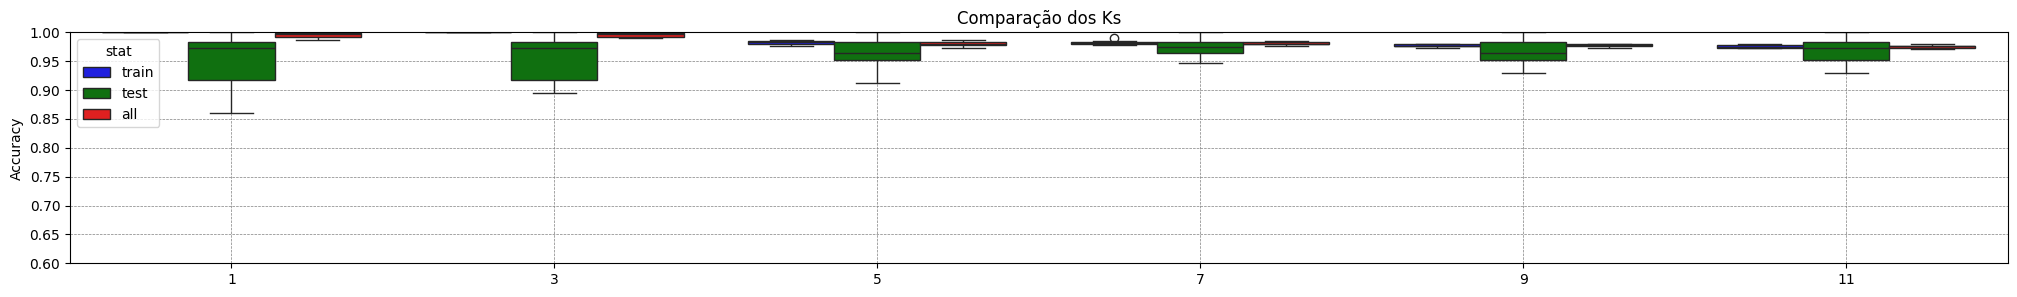

In [26]:
#4.Análise da performance do modelo variando o parâmetro de k
fig = plt.figure(figsize=(25, 3))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='k', y='accuracy', data=accuracies, hue='stat', palette=['blue', 'green', 'red'], ax=ax, hue_order=['train', 'test', 'all'])
ax.set_title('Comparação dos Ks')
ax.set_ylabel('Accuracy')
ax.set_xlabel('')
ax.set_ylim(0.6, 1.0)
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)


Matriz de confusão:
[[21  0]
 [ 0 35]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        35

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Acurácia: 1.0000


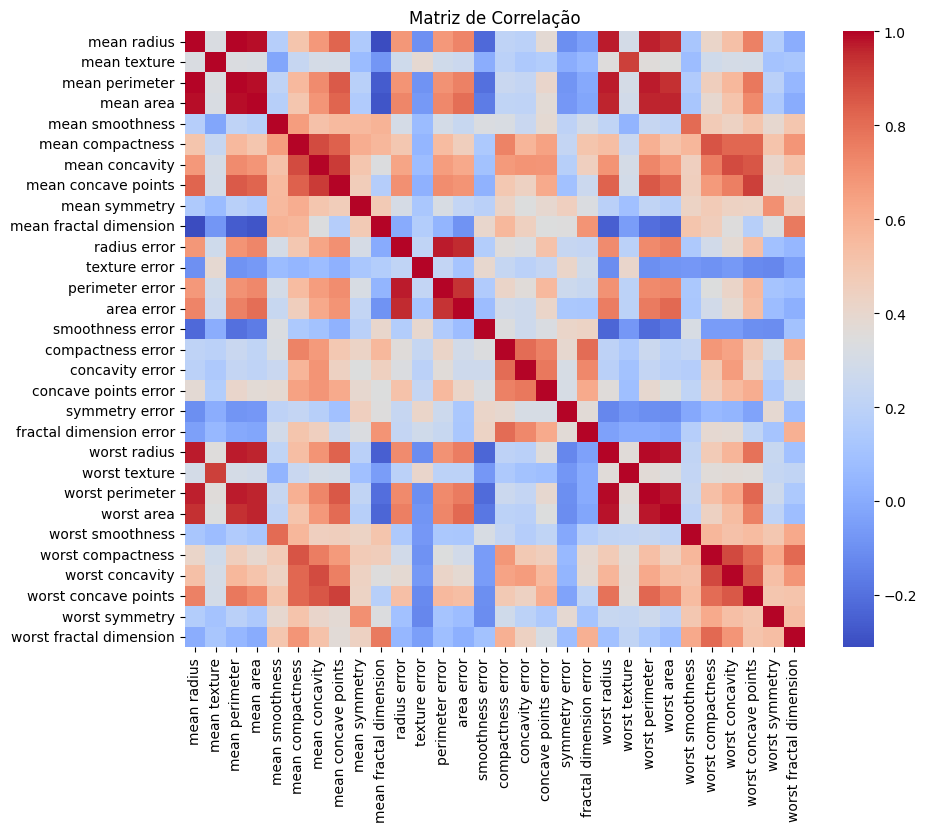

In [ ]:
#5.Treinamento e avaliação de modelos de classificação usando o algoritmo de Regressão Logística

df = pd.DataFrame(data.data, columns=data.feature_names)
#df['target'] = X.target

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")

plt.figure(figsize=(10,8))
seaborn.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de Correlação')
plt.show()


Métricas de validação cruzada para Regressão Logística (SEM re-treinamento):
Accuracy: 0.9766
Precision: 0.9731
Recall: 0.9906
F1: 0.9816

Métricas de validação cruzada para KNN (SEM re-treinamento):
Accuracy: 0.9668
Precision: 0.9613
Recall: 0.9875
F1: 0.9740

Melhores hiperparâmetros encontrados:
KNN: {'n_neighbors': 7}
Regressão Logística: {'C': 1, 'penalty': 'l2'}

Desempenho FINAL no teste para KNN (COM re-treinamento):
Acurácia:  0.9821
Precisão:  0.9722
Recall:    1.0000
F1-score:  0.9859

Desempenho FINAL no teste para Regressão Logística (COM re-treinamento):
Acurácia:  1.0000
Precisão:  1.0000
Recall:    1.0000
F1-score:  1.0000


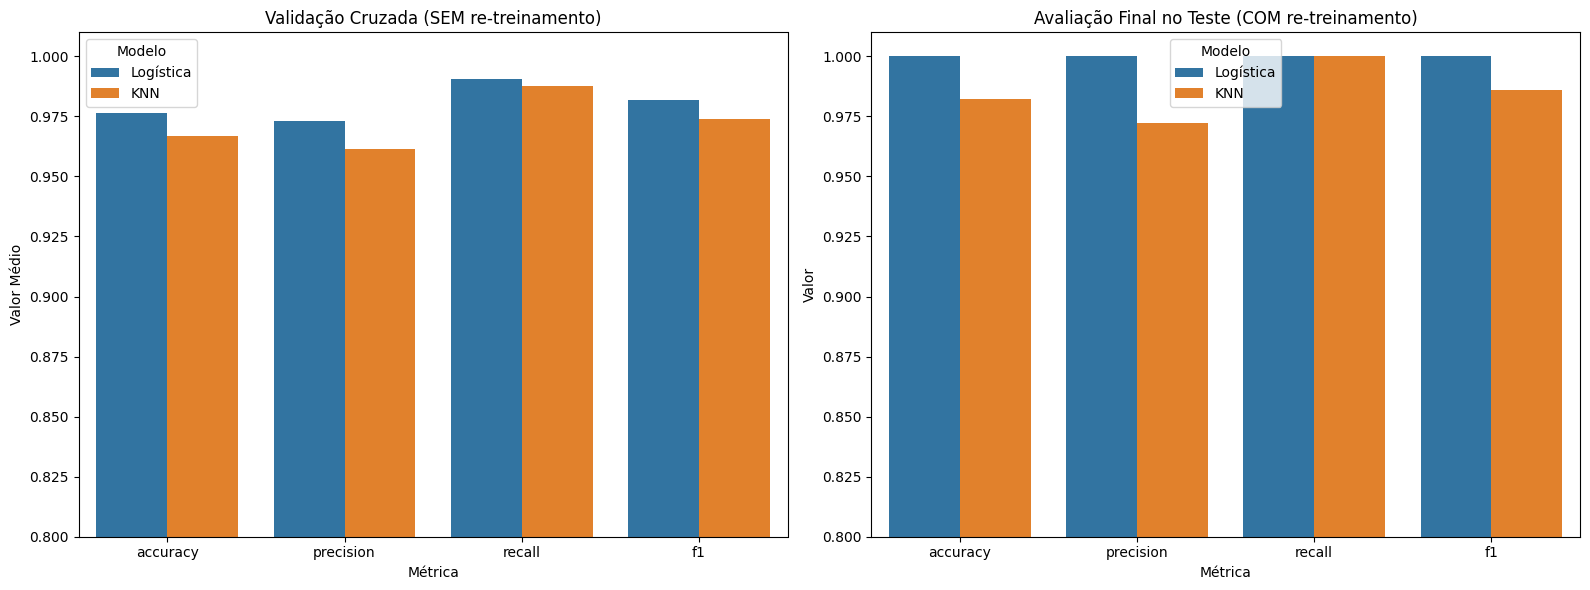

In [ ]:
#6-Comparação de modelos de classificação KNN e Regressão Logística com validação cruzada 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=10000, random_state=42)
knn_model = KNeighborsClassifier()

cv_metrics = ['accuracy', 'precision', 'recall', 'f1']

log_cv = cross_validate(log_model, X_train_scaled, y_train, cv=5, scoring=cv_metrics)
knn_cv = cross_validate(knn_model, X_train_scaled, y_train, cv=5, scoring=cv_metrics)

def print_cv_results(name, scores):
    print(f"\nMétricas de validação cruzada para {name} (SEM re-treinamento):")
    for metric in cv_metrics:
        print(f"{metric.capitalize()}: {np.mean(scores[f'test_{metric}']):.4f}")

print_cv_results("Regressão Logística", log_cv)
print_cv_results("KNN", knn_cv)

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 21)}, 
                        cv=5, scoring='accuracy')
log_grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid={
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  
}, cv=5, scoring='accuracy')

knn_grid.fit(X_train_scaled, y_train)
log_grid.fit(X_train_scaled, y_train)

print("\nMelhores hiperparâmetros encontrados:")
print("KNN:", knn_grid.best_params_)
print("Regressão Logística:", log_grid.best_params_)

knn_best = knn_grid.best_estimator_
log_best = log_grid.best_estimator_

knn_best.fit(X_train_scaled, y_train)
log_best.fit(X_train_scaled, y_train)

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\nDesempenho FINAL no teste para {name} (COM re-treinamento):")
    print(f"Acurácia:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precisão:  {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")

evaluate_model("KNN", knn_best, X_test_scaled, y_test)
evaluate_model("Regressão Logística", log_best, X_test_scaled, y_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cv_results = pd.DataFrame({
    'Modelo': ['Logística'] * 4 + ['KNN'] * 4,
    'Métrica': cv_metrics * 2,
    'Valor Médio': [np.mean(log_cv[f'test_{m}']) for m in cv_metrics] +
                   [np.mean(knn_cv[f'test_{m}']) for m in cv_metrics]
})

def evaluate_final(model, X, y):
    y_pred = model.predict(X)
    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
    }

log_final = evaluate_final(log_best, X_test_scaled, y_test)
knn_final = evaluate_final(knn_best, X_test_scaled, y_test)
final_results = pd.DataFrame({
    'Modelo': ['Logística'] * 4 + ['KNN'] * 4,
    'Métrica': cv_metrics * 2,
    'Valor': [log_final[m] for m in cv_metrics] +
             [knn_final[m] for m in cv_metrics]
})

seaborn.barplot(data=cv_results, x='Métrica', y='Valor Médio', hue='Modelo', ax=axes[0])
axes[0].set_title('Validação Cruzada (SEM re-treinamento)')
axes[0].set_ylim(0.8, 1.01)

seaborn.barplot(data=final_results, x='Métrica', y='Valor', hue='Modelo', ax=axes[1])
axes[1].set_title('Avaliação Final no Teste (COM re-treinamento)')
axes[1].set_ylim(0.8, 1.01)

plt.tight_layout()
plt.show()